### Import Packages

In [3]:
suppressMessages(library(gglasso))
suppressMessages(library(bst))
suppressMessages(library(IRdisplay))
suppressMessages(library(caret))
suppressMessages(library(earth))
suppressMessages(library(h2o))
suppressMessages(library(xgboost))
suppressMessages(library(REEMtree))
suppressMessages(library(fastDummies))
library(data.table)
library(desirability)
library(doParallel)
library(MASS)
library(devtools)
library(ILAMM)
library(devtools)
library(tfHuber)
library(randomGLM)
library(plyr)
set.seed(18)

### Read in data and create train-test-split and dummy variables

In [4]:
load_dummy_std <- function(){

    dataset_3 <- data.table::fread('./data/processed/dataset_3.csv', drop = 1, check.names = TRUE)
    cat_columns <- c("Home", "Visitor", "Last.Five", "Day.of.Week", "Month")
    dataset_3[ , (cat_columns) := lapply(.SD,as.factor), .SDcols = cat_columns]
    X <- dataset_3[,1:(ncol(dataset_3)-1)]
    y <- dataset_3[,'Attendance']
    X <- dummy_cols(X, select_columns = cat_columns, ignore_na = TRUE, remove_selected_columns = TRUE)
    training_indices <- 1:(nrow(X)-2960)
    X_train <- X[training_indices,]
    X_test <- X[-training_indices,]
    suppressWarnings(preProcValues <- preProcess(X_train, method = c("center", "scale")))
    X_train <- predict(preProcValues, X_train)
    X_test <- predict(preProcValues, X_test)
    y_train <- y[training_indices]
    y_test <- y[-training_indices]
    
    return(list(X.train = X_train, X.test = X_test, y.train =  y_train, y.test = y_test))
}
data <- load_dummy_std()
head(data$X.train)

V.Pop,H.Pop,Curr.Win..,LS.Win..,Last.Game,Last.Attendance.vs.Opp,Capacity,Playoffs.,Home_Atlanta Hawks,Home_Boston Celtics,⋯,Day.of.Week_Wednesday,Month_April,Month_December,Month_February,Month_January,Month_June,Month_March,Month_May,Month_November,Month_October
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.53671550,-0.592292553,-0.8984323,-0.57431379,-1.6754137,-0.41414101,0.4664760,-0.2788241,-0.2179768,-0.2219862,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
-0.44269478,-0.003514696,0.9675251,-0.01024471,0.2845056,0.45442179,-0.8678965,-0.2788241,-0.2179768,4.5044037,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
0.96761600,-0.690422196,-1.1993932,-1.36421592,-0.5961520,0.69552455,0.5009336,-0.2788241,-0.2179768,-0.2219862,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
-0.34867406,-0.690422196,1.0965083,0.41052831,0.8931711,0.07621655,0.6542702,-0.2788241,-0.2179768,-0.2219862,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
-0.44269478,-0.690422196,-0.1226221,0.13375800,-0.2905754,0.63920136,0.8601546,-0.2788241,-0.2179768,-0.2219862,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
-0.06661191,-0.494162910,0.7345231,0.98191169,0.3562353,-0.17970810,-0.5147056,-0.2788241,-0.2179768,-0.2219862,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096


### Define metrics

In [5]:
metrics <- function(preds)
{
    r2 <- function(preds){
        rss <- sum((preds - (as.matrix(data$y.test[,'Attendance']))) ^ 2)
        tss <- sum((as.matrix((data$y.test[,'Attendance']) - mean(as.matrix(data$y.test[,'Attendance']))) ^ 2))
        rsq <- 1 - rss/tss
        return(rsq)
    }
    
    mae <- function(preds)
        {
        error <- as.matrix(data$y.test[,'Attendance']) - preds  
        mae <- mean(abs(error))
        return(mae)
        }
    
    rmse <- function(preds)
        {
        error <- as.matrix(data$y.test[,'Attendance']) - preds
        rmse = sqrt(mean(error^2))
        return(rmse)
        }
    colnames = c("$R^2$","MAE", "RMSE")
    mat = matrix(c(r2(preds),mae(preds),rmse(preds)), nrow = 1, ncol = 3)
    colnames(mat) = colnames
    return(mat)
}

### Grouped Lasso

Last.Game,Capacity,Home_Los.Angeles.Lakers,LS.Win..,Home_Utah.Jazz,Home_Dallas.Mavericks,Curr.Win..,Home_Miami.Heat,Home_New.York.Knicks,Visitor_Los.Angeles.Lakers,Home_Cleveland.Cavaliers,H.Pop,Home_Chicago.Bulls,V.Pop,Home_Portland.Trail.Blazers
928.3619,510.0042,223.7919,222.3718,209.999,209.0234,201.4591,193.2703,174.9298,174.811,170.5715,166.2883,138.0806,134.2895,132.7285


$R^2$,MAE,RMSE
0.585459,939.0322,1278.388


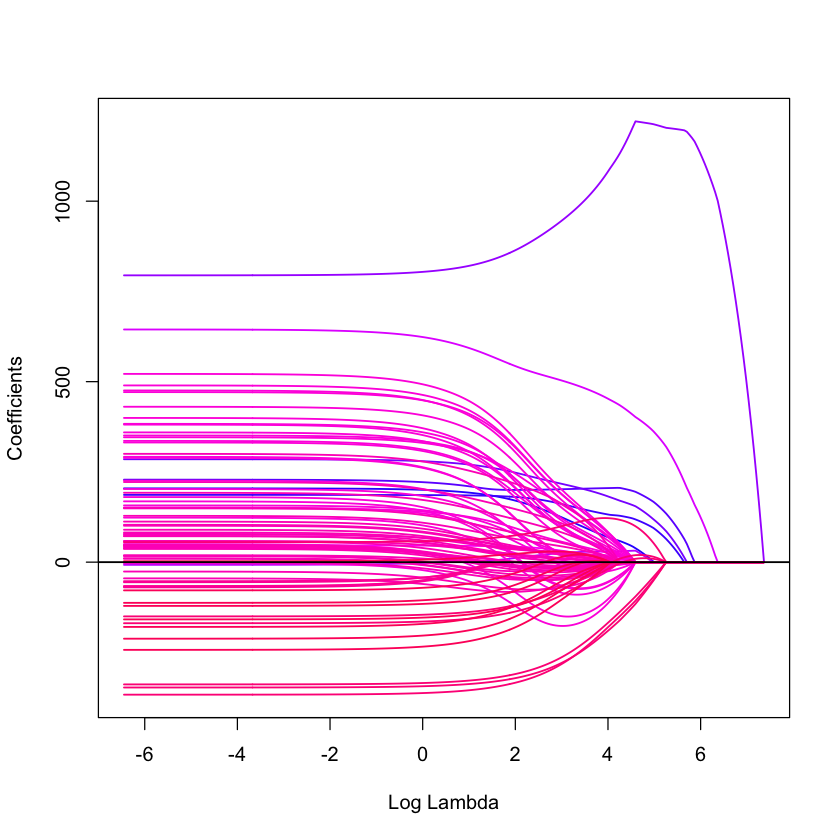

In [43]:
groups <- rep(1:13, c(rep(1,7),1,26,29,5,6,8))

g_lass <- cv.gglasso(x=as.matrix(X.train), y=as.matrix(y.train), group=groups, loss="ls", pred.loss= c("L1"), nlambda = 250,lambda.factor=1e-8, nfolds=5, intercept = TRUE)
g_lass_coefficients <- coef(g_lass$gglasso.fit, s = g_lass$lambda.min)
display(t(g_lass_coefficients[order(g_lass_coefficients[,c(1)], decreasing = TRUE),][2:16]))
preds <- predict(g_lass$gglasso.fit, newx = as.matrix(X.test), s = g_lass$lambda.min)
plot(g_lass$gglasso.fit, group = FALSE, log.l = TRUE)
metrics(preds)

In [27]:
getModelInfo("xgbLinear")

parameter,class,label
<fct>,<fct>,<fct>
nrounds,numeric,# Boosting Iterations
lambda,numeric,L2 Regularization
alpha,numeric,L1 Regularization
eta,numeric,Learning Rate


In [6]:
X.train = data.frame(as.matrix(data$X.train))
X.test = data.frame(as.matrix(data$X.test))
y.train = c(as.matrix(data$y.train))
y.test = c(as.matrix(data$y.test))

In [58]:
cl <- makePSOCKcluster(7)
registerDoParallel(cl)

ctrl <- gafsControl(allowParallel = TRUE, functions = rfGA)
obj <- gafs(X.train, y.train, iters = 200, popSize = 50, pcrossover = 0.8, pmutation = 0.1, elite = 0, suggestions = NULL, differences = TRUE, gafsControl = ctrl)
plot(obj) + theme_bw()

obj$fit()

obj$fitness_intern <- function (object, x, y, maximize, p) {
  RMSE <- rfStats(object)[1]
  d_RMSE <- dMin(0, 4)
  d_Size <- dMin(1, p, 2)
  overall <- dOverall(d_RMSE, d_Size)
  D <- predict(overall, data.frame(RMSE, ncol(x)))
  c(D = D, RMSE = as.vector(RMSE))
  }

ga_ctrl_d <- gafsControl(functions = rfGA2,
                         method = "repeatedcv",
                         repeats = 5,
                         metric = c(internal = "D", external = "RMSE"),
                         maximize = c(internal = TRUE, external = FALSE))

set.seed(10)
rf_ga_d <- gafs(x = x, y = y,
                iters = 150,
                gafsControl = ga_ctrl_d)

rf_ga_d

In [ ]:
obj <- safs(x = predictors, 
            y = outcome,
            iters = 100)

$R^2$,MAE,RMSE
0.5761534,961.4317,1292.657


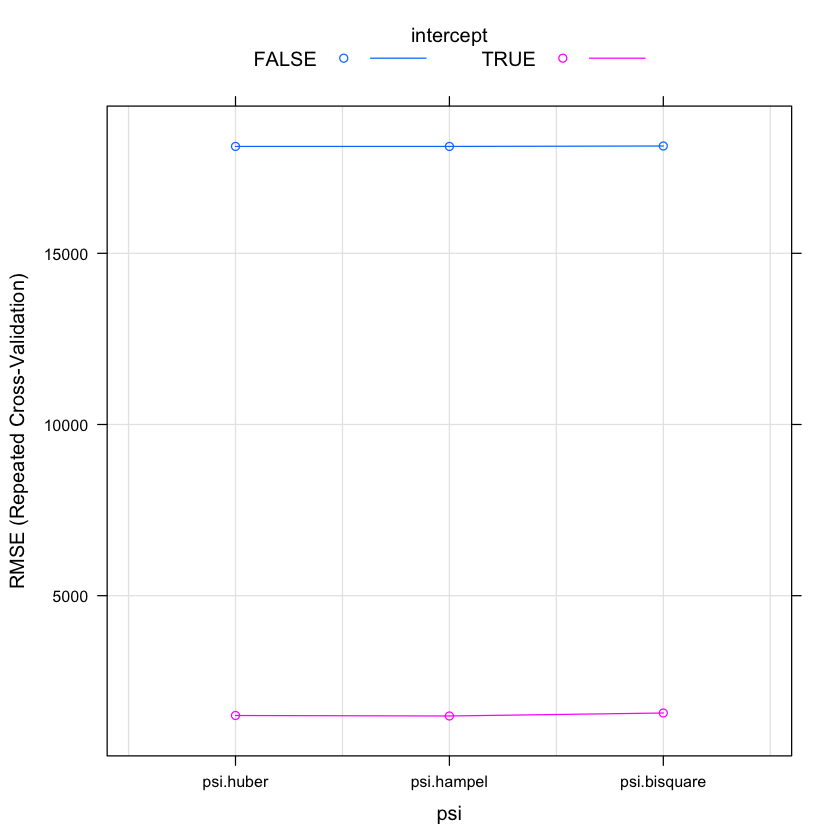

In [19]:
#Robust Linear Model

to.drop <- c('Home_Atlanta.Hawks','Visitor_Atlanta.Hawks', "Last.Five_0", "Day.of.Week_Friday", "Month_April", 'Home_Detroit.Pistons',
            'Home_Golden.State.Warriors', 'Home_Milwaukee.Bucks')
X.train <- X.train[ , !(names(X.train) %in% to.drop)]
X.test <- X.test[, !(names(X.test) %in% to.drop)]
cl <- makePSOCKcluster(7)
registerDoParallel(cl)

grid <- expand.grid(intercept = c(TRUE, FALSE), psi = c("psi.huber","psi.hampel", "psi.bisquare"))
tc <- trainControl(method = 'repeatedcv', number = 5, search = 'grid', summaryFunction = defaultSummary,
                  verboseIter = FALSE)

rlm <- train(X.train, y.train, method = "rlm", metric = "RMSE", 
      maximize = FALSE, trControl = tc, tuneGrid = grid)

plot(rlm)  

preds = predict(rlm, newdata = X.test)


metrics(preds)

stopCluster(cl)

In [21]:
#Bagged MARS using gCV Pruning

cl <- makePSOCKcluster(7)
registerDoParallel(cl)

grid <- expand.grid(degree = c(1))
tc <- trainControl(method = 'none',
                  verboseIter = FALSE)

bagEarthgcv <- train(X.train, y.train, method = "bagEarthGCV", metric = "RMSE", 
      maximize = FALSE, trControl = tc, tuneGrid = grid)

plot(bagEarthgcv)  

preds = predict(bagEarthgcv, newdata = X.test)


metrics(preds)

stopCluster(cl)

ERROR: Error in plot.train(bagEarthgcv): There are no tuning parameters with more than 1 value.


Warning message in LiblineaR::LiblineaR(data = as.matrix(x), target = y, cost = param$cost, :
“No value provided for svr_eps. Using default of 0.1”


$R^2$,MAE,RMSE
0.545341,1014.685,1338.819


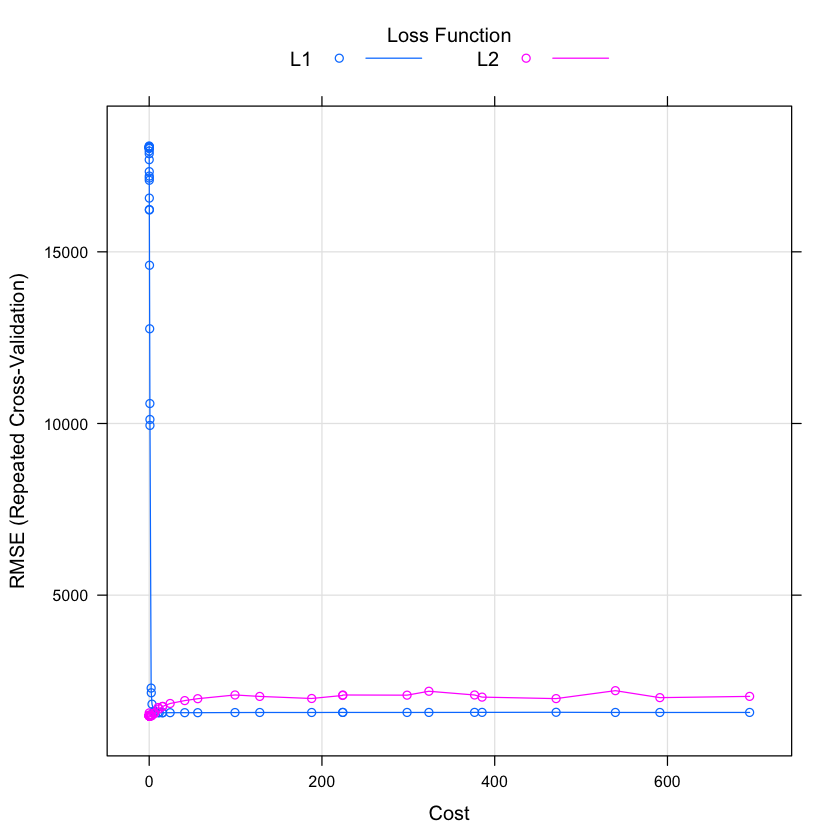

In [70]:
#L2 Regularized Support Vector Machine (dual) with Linear Kernel

cl <- makePSOCKcluster(7)
registerDoParallel(cl)

grid <- expand.grid(cost = 2^runif(50, min = -10, max = 10), Loss = c("L1", "L2"))
tc <- trainControl(method = 'cv', number = 5, search = 'grid', summaryFunction = defaultSummary,
                  verboseIter = FALSE)

regSVM <- train(X.train, y.train, method = "svmLinear3", metric = "RMSE", 
      maximize = FALSE, trControl = tc, tuneGrid = grid)

plot(regSVM)  

preds = predict(regSVM, newdata = X.test)


metrics(preds)

stopCluster(cl)

In [2]:
X.train

ERROR: Error in eval(expr, envir, enclos): object 'X.train' not found


eXtreme Gradient Boosting 

11838 samples
   90 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9470, 9471, 9470, 9471, 9470 
Resampling results across tuning parameters:

  lambda        alpha         nrounds  RMSE      Rsquared   MAE     
  0.0000000000  0.0000000000   50      1345.939  0.6885505  880.1535
  0.0000000000  0.0000000000  100      1333.322  0.6951104  872.2563
  0.0000000000  0.0000000000  150      1333.093  0.6958215  871.8325
  0.0000000000  0.0001000000   50      1345.939  0.6885505  880.1535
  0.0000000000  0.0001000000  100      1333.322  0.6951104  872.2563
  0.0000000000  0.0001000000  150      1333.093  0.6958215  871.8325
  0.0000000000  0.0003162278   50      1345.939  0.6885505  880.1535
  0.0000000000  0.0003162278  100      1333.322  0.6951104  872.2563
  0.0000000000  0.0003162278  150      1333.093  0.6958216  871.8325
  0.0000000000  0.0010000000   50      1345.939  0.6885505  880.1535
  0.0000000000  0.0010000

$R^2$,MAE,RMSE
0.4636894,991.6014,1454.076


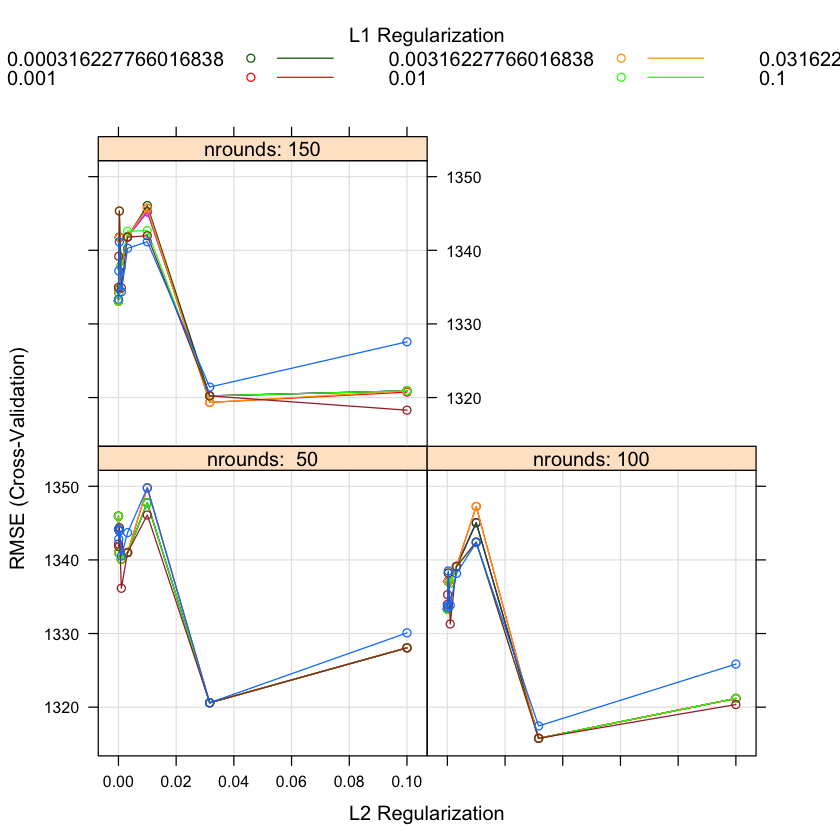

In [59]:
cl <- makePSOCKcluster(7)
registerDoParallel(cl)

grid <- expand.grid(lambda = c(0, 10^seq(-1, -4, length = 8 - 
            1)), alpha = c(0, 10^seq(-1, -4, length = 8 - 1)), 
            nrounds = floor((1:3) * 50), eta = 0.3)
tc <- trainControl(method = 'cv', number = 5, search = 'grid', summaryFunction = defaultSummary, selectionFunction = "oneSE",
                  verboseIter = FALSE)

xgbLinear <- train(X.train, y.train, method = "xgbLinear", metric = "RMSE", 
      maximize = FALSE, trControl = tc, tuneGrid = grid)

plot(xgbLinear)  

preds = predict(xgbLinear, newdata = X.test)

print(xgbLinear)
metrics(preds)

stopCluster(cl)


In [ ]:
to.drop <- c('Home_Atlanta.Hawks','Visitor_Atlanta.Hawks', "Last.Five_0", "Day.of.Week_Friday", "Month_April", 'Home_Detroit.Pistons',
            'Home_Golden.State.Warriors', 'Home_Milwaukee.Bucks')
X.train <- X.train[ , !(names(X.train) %in% to.drop)]
X.test <- X.test[, !(names(X.test) %in% to.drop)]

grid <- expand.grid(maxInteractionOrder = 1:3)
            
tc <- trainControl(method = 'repeatedcv', number = 5, search = 'grid', summaryFunction = defaultSummary, verboseIter = FALSE)

ensembleGLM <- train(X.train, y.train, method = "randomGLM", metric = "RMSE", maximize = FALSE, trControl = tc, tuneGrid = grid)

plot(ensembleGLM)  

preds = predict(ensembleGLM, newdata = X.test)

metrics(preds)

In [5]:
X.train.intercept <- cbind(intercept = rep(1,nrow(X.train)), X.train)
X.train.intercept
X.test.intercept <- cbind(intercept = rep(1,nrow(X.test)), X.test)
X.test.intercept

intercept,V.Pop,H.Pop,Curr.Win..,LS.Win..,Last.Game,Last.Attendance.vs.Opp,Capacity,Playoffs.,Home_Atlanta.Hawks,⋯,Day.of.Week_Wednesday,Month_April,Month_December,Month_February,Month_January,Month_June,Month_March,Month_May,Month_November,Month_October
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.53671550,-0.592292553,-0.89843234,-0.57431379,-1.6754137,-0.41414101,0.46647597,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,-0.44269478,-0.003514696,0.96752507,-0.01024471,0.2845056,0.45442179,-0.86789653,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,0.96761600,-0.690422196,-1.19939321,-1.36421592,-0.5961520,0.69552455,0.50093362,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,-0.34867406,-0.690422196,1.09650830,0.41052831,0.8931711,0.07621655,0.65427016,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,-0.44269478,-0.690422196,-0.12262209,0.13375800,-0.2905754,0.63920136,0.86015462,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,-0.06661191,-0.494162910,0.73452311,0.98191169,0.3562353,-0.17970810,-0.51470562,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,-0.16063263,-0.788551839,1.09650830,0.22248958,-1.4875898,-0.05520422,0.03144814,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,0.02740881,0.781522447,-1.01881668,0.15284561,1.0507276,0.39958080,2.95948695,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096
1,-0.63073622,-0.396033267,0.96752507,0.98191169,0.8944150,-0.07694299,0.90064236,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,2.1006,-0.08037997,-0.4729413,-0.1927284,-0.4224709,-0.1294096


intercept,V.Pop,H.Pop,Curr.Win..,LS.Win..,Last.Game,Last.Attendance.vs.Opp,Capacity,Playoffs.,Home_Atlanta.Hawks,⋯,Day.of.Week_Wednesday,Month_April,Month_December,Month_February,Month_January,Month_June,Month_March,Month_May,Month_November,Month_October
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.53671550,-0.592292553,0.01123250,0.69163671,-1.028188394,-1.19500762,-1.47176685,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,1.24967816,1.075911376,-1.09511662,0.02844706,0.284505639,0.10042563,-0.86789653,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,0.02740881,1.566559590,-0.68023570,-2.70051892,1.478203087,1.09571560,2.73551222,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,-0.63073622,0.585263161,-0.46203907,-0.46914712,-0.770293357,-0.63325796,-1.24434636,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,-0.63073622,-0.396033267,-0.57882037,-0.43793912,0.325967864,0.54656455,0.31486231,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,-0.16063263,-0.690422196,0.51237329,-0.08141139,0.465280939,0.56212753,-0.21233974,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,-0.34867406,0.781522447,0.58410917,1.67949406,1.088043553,0.93316887,0.80157661,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,-0.06661191,-0.396033267,0.51237329,0.73929589,0.731883043,0.72368614,0.73438420,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096
1,-0.53671550,0.192744590,1.48636466,1.45246270,0.199093456,0.49715824,-0.72317440,-0.2788241,-0.2179768,⋯,-0.5105691,-0.3769627,-0.4300806,-0.4063786,-0.4760142,-0.08037997,2.114249,-0.1927284,-0.4224709,-0.1294096


$R^2$,MAE,RMSE
0.5212138,987.9821,1373.883


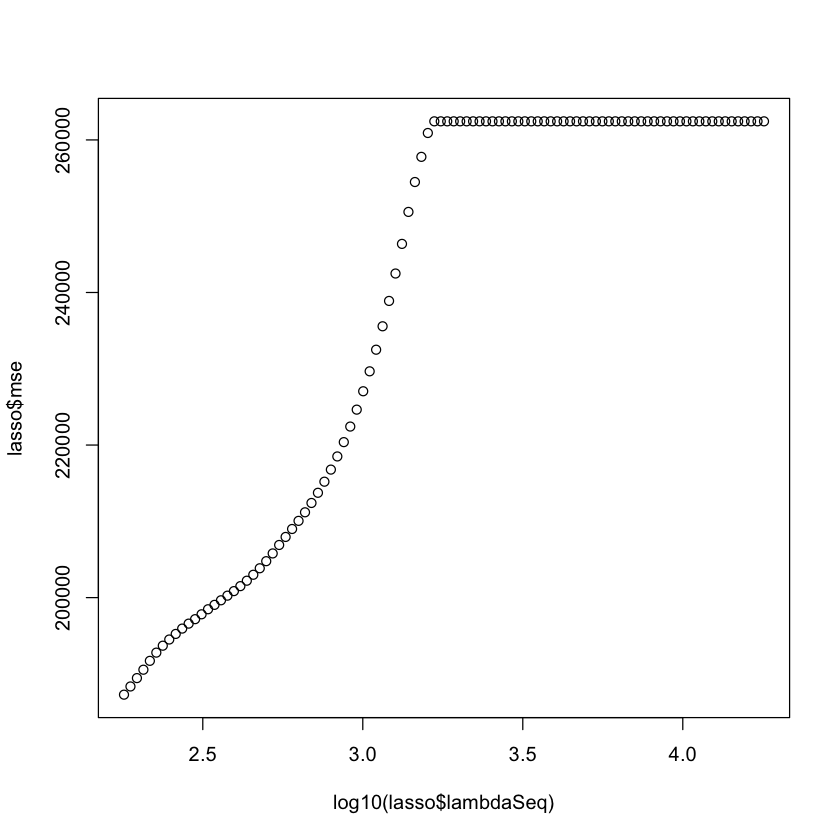

In [42]:
lasso <- cvNcvxReg(X = as.matrix(X.train), Y = y.train, lSeq = NULL, nlambda = 100L, penalty = "Lasso", phi0 = 0.001, gamma = 1.5, epsilon_c = 0.001, epsilon_t = 0.001, 
                   iteMax = 500L, nfolds = 5L, intercept = TRUE, itcpIncluded = FALSE)

plot(log10(lasso$lambdaSeq), lasso$mse)
preds <- as.matrix(X.test.intercept) %*% c(lasso$beta)
metrics(preds)

$R^2$,MAE,RMSE
0.5152193,943.7345,1382.457


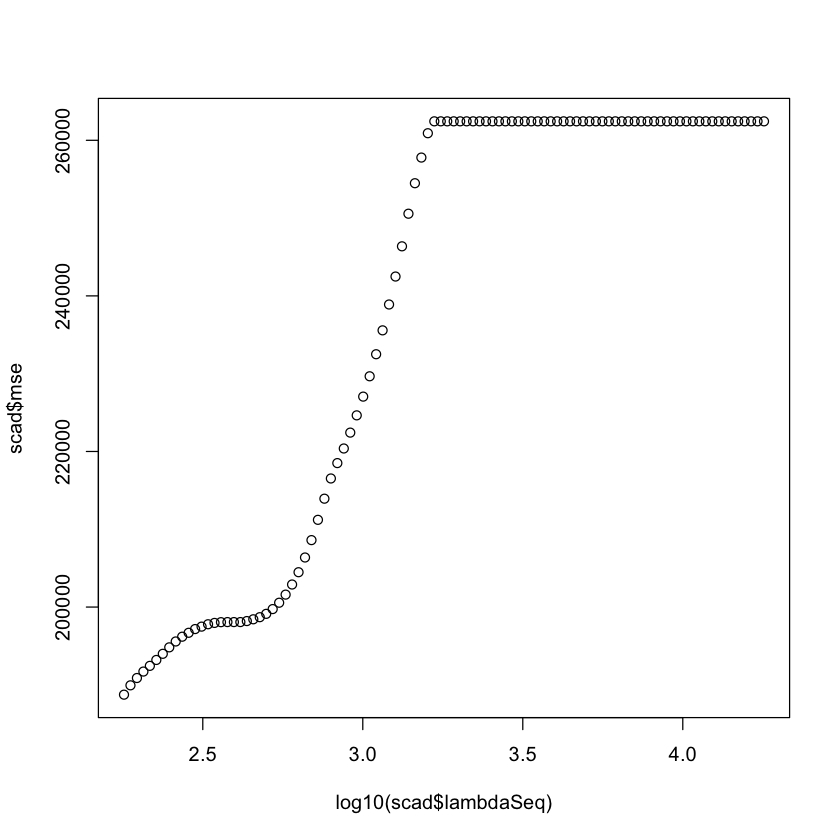

In [43]:
scad <- cvNcvxReg(X = as.matrix(X.train), Y = y.train, lSeq = NULL, nlambda = 100L, penalty = "SCAD", phi0 = 0.001, gamma = 1.5, epsilon_c = 0.001, epsilon_t = 0.001, 
                   iteMax = 500L, nfolds = 5L, intercept = TRUE, itcpIncluded = FALSE)

plot(log10(scad$lambdaSeq), scad$mse)
preds <- as.matrix(X.test.intercept) %*% c(scad$beta)
metrics(preds)

In [ ]:
mcp <- cvNcvxReg(X = as.matrix(X.train), Y = y.train, lSeq = NULL, nlambda = 100L, penalty = "MCP", phi0 = 0.001, gamma = 1.5, epsilon_c = 0.001, epsilon_t = 0.001, 
                   iteMax = 500L, nfolds = 5L, intercept = TRUE, itcpIncluded = FALSE)

plot(log10(mcp$lambdaSeq), mcp$mse)
preds <- as.matrix(X.test.intercept) %*% c(mcp$beta)
metrics(preds)

In [33]:
huber.lasso <- cvNcvxHuberReg(X = as.matrix(X.train), Y = y.train, lSeq = NULL, nlambda = 50L, penalty = "Lasso", tSeq = NULL, ntau = 5L, phi0 = 0.001, gamma = 1.5, 
                              epsilon_c = 0.001, epsilon_t = 0.001, iteMax = 500L, nfolds = 5L, intercept = TRUE, itcpIncluded = FALSE)

plot(log10(huber.lasso$tauSeq), huber.lasso$mse[which(huber.lasso$lambdaSeq == huber.lasso$lambdaMin, arr.ind = T)[,"row"],])

preds <- as.matrix(X.test.intercept) %*% c(huber.lasso$beta)
metrics(preds)

$R^2$,MAE,RMSE
0.5212138,987.9823,1373.883


In [ ]:
huber.scad <- cvNcvxHuberReg(X = as.matrix(X.train), Y = y.train, lSeq = NULL, nlambda = 50L, penalty = "SCAD", tSeq = NULL, ntau = 5L, phi0 = 0.001, gamma = 1.5, 
                              epsilon_c = 0.001, epsilon_t = 0.001, iteMax = 500L, nfolds = 5L, intercept = TRUE, itcpIncluded = FALSE)

plot(log10(huber.scad$tauSeq), huber.scad$mse[which(huber.scad$lambdaSeq == huber.scado$lambdaMin, arr.ind = T)[,"row"],])

preds <- as.matrix(X.test.intercept) %*% c(huber.scad$beta)
metrics(preds)

In [ ]:
huber.mcp <- cvNcvxHuberReg(X = as.matrix(X.train), Y = y.train, lSeq = NULL, nlambda = 50L, penalty = "MCP", tSeq = NULL, ntau = 5L, phi0 = 0.001, gamma = 1.5, 
                              epsilon_c = 0.001, epsilon_t = 0.001, iteMax = 500L, nfolds = 5L, intercept = TRUE, itcpIncluded = FALSE)

plot(log10(huber.MCP$tauSeq), huber.mcp$mse[which(huber.mcp$lambdaSeq == huber.mcp$lambdaMin, arr.ind = T)[,"row"],])
preds <- as.matrix(X.test.intercept) %*% c(huber.mcp$beta)
metrics(preds)

In [46]:
huber.adaptive <- huberReg(X = as.matrix(X.train), Y = y.train, epsilon = 1e-07, constTau = 1.345, iteMax = 1e4)
preds <- as.matrix(X.test.intercept) %*% c(huber.adaptive$theta)
metrics(preds)

$R^2$,MAE,RMSE
0.5555378,961.8926,1323.721


In [ ]:
X <- dataset_3[,-ncol(dataset_3)][,-1]
y <- dataset_3[,ncol(dataset_3)]
training_indices <- 1:(nrow(X)-2960)
X_train <- X[training_indices,]
X_test <- X[-training_indices,]
y_train <- y[training_indices]
y_test <- y[-training_indices]

In [ ]:
gb <- bst(X_train, y_train, cost = 0.5, family = c("huber"), ctrl = bst_control(mstop = 50, trace = TRUE), 
          control.tree = list(maxdepth = 1),learner = c("tree"))
gb.preds <- predict(gb, newdata=X_test, mstop = 50, type=c("response"), n.cores=8)
display(metrics(gb.preds))

In [ ]:
gb.1 <- bst(X_train, y_train, cost = 0.5, family = c("gaussian"), ctrl = bst_control(mstop = 50, trace = TRUE), control.tree = list(maxdepth = 1),learner = c("ls"))
gb.1.preds <- predict(gb.1, newdata=X_test, mstop = 50, type=c("response"), n.cores=4)
display(metrics(gb.1.preds))


In [ ]:
gb.2 <- bst(X_train, y_train, cost = 0.5, family = c("gaussian"), ctrl = bst_control(mstop = 50, trace = TRUE), control.tree = list(maxdepth = 1),learner = c("tree"))
gb.2.preds <- predict(gb.2, newdata=X_test, mstop = 50, type=c("response"), n.cores=4)
display(metrics(gb.2.preds))

In [ ]:
gb.3 <- rbst(x, y, cost = 0.5, rfamily = c("tgaussian", "thuber","thinge", "tbinom", "binomd","texpo", "tpoisson", "clossR", "closs", "gloss", "qloss"), ctrl=bst_control(),
control.tree=list(maxdepth = 1), learner=c("ls","sm","tree"),del=1e-10)

In [ ]:
mars <- earth(X_train, y_train, nfold = 5, ncross = 30)
display(summary(mars, digits = 3)) 
mars.preds <- predict(mars, newdata = X_test, type = c("response"), trace = True)
display(metrics(mars.preds))

In [ ]:
cbind(X_train,y_train)

In [ ]:
reem <- REEMtree(y ~ . ,data = `, random, subset=NULL, initialRandomEffects=rep(0,TotalObs),
ErrorTolerance=0.001, MaxIterations=1000, verbose=FALSE, tree.control=rpart.control(),
cv=TRUE, cpmin = 0.001, no.SE =1,
lme.control=lmeControl(returnObject=TRUE), method="REML", correlation=NULL)